## Network Optimization June 8 2021

### 274426	Serilli	Leonardo

### Exercise 1

The graph ``11_net08062021.gml``  contains a set of potential customers that a telecom company can connect with a network rooted in node 1.

The number of customers in each node is stored in the node attribute ``customer``.

Each edge $uv$ has an activation cost \[``cost`` attribute in the graph\].

#### Questions

1.	Find the set of links that connects all nodes at minimum cost. 
2.	Find the set of links that connects at least $95\%$ of the customers at minimum cost with the constraint that each node in the network can accept up to 2 connections. 
3.	From network 1, suppose that you can install one hub in one of the nodes \[6,11,14\] with the following features:
    a.	If the hub is installed in node $k$, the cost of a link from node $k$ to any other node is zero;
    b.	The hub can accept up to 6 connections.

In [26]:
import networkx as nx
import gurobipy as gb
import os
import matplotlib.pyplot as plt

In [27]:
# Drawing functions

def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        

    
    #edges_in_sol = [(u,v)  for u,v in G.edges() if x[u,v].x > 0.1]

    
    plt.axis('off')
    plt.show()
    
class args:
    filename = None
    figsize = 30,60
    scale = 40

## Prize Collecting Steiner Tree (PCST)

### Problem definition

>**Given**
> * A symmetric graph $G=(V,E)$ and a cost $c_e > 0$ for each edge in $E$;
> * A root node $\{0\}$;
> * A revenue $p_j > 0$ for each node $j \in V \setminus \{0\}$;

>
>**Find**
>A subtree $T$ rooted in $\{0\}$ that **maximizes** the sum of the revenues of 
>the nodes in $T$ **minus** the sum of the costs of the edges in $T$

### Directed formulation

Consider the bidirected graph $B=(V,A)$ that is obtained from $G$ by replacing each edge $e = \{i, j\}$ in $E$ with two directed arcs $(i, j)$ and
$(j, i)$ (with corresponding weights $c_{ij} = c_{ji} = c_e )$ and a cost $c_e > 0$ for each edge in $E$

> **PCST** is equivalent to find an optimal **arborescence** in $B$ rooted in $\{0\}$


#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

#### Directed cut formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
\sum_{(i,j)\in \delta^+(S) x_{ij}} x_{ij}& \ge y_k \;\; \forall S \subset V, 0 \in S, k \in V\setminus S\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$

### Formulation with *positional* variables (MTZ formulation)

#### Variables
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the arborescence} \\
0 \text{ otherwise}
\end{cases}
$$

$$
y_j = \begin{cases} 1 \text{ if node j is in the arborescence}\\
0 \text{ otherwise}
\end{cases}
$$

$$ 
u_j = \{\text{number of arcs in the dipath (if any) induced by $x$ from \{0\} to $j$}\}
$$

#### MTZ formulation

$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} - \sum_{j \in V \setminus \{0\}} p_j y_j \\
\text{subject}& \text{ to} \\
y_0 & = 1 \\
\sum_{i \in \delta^-(j)} x_{ij} & = y_j \;\; \forall j \in V\\
(n+1)x_{ij} + u_i - u_j &\le n \;\; \forall (i,j) \in A \\
x_{jk} &\le y_j \;\; \forall k \in \delta^+(j), \;\; \forall j \in V \setminus\{0\}\\
0 \le u_j & \le n \;\; \forall j \in V \\ 
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
y_j & \in \{0,1\} \;\; \forall j \in V
\end{align}
$$


## **Ex1_Q2 ->** Find the set of links that connects at least $95\%$ of the customers at minimum cost with the constraint that each node in the network can accept up to 2 connections. 

**Note** that there is no profit for adding a node to the network, so we can avoid variable $p_j$ and it's role in the objective function when we will define the model

In [28]:
# Read the graph in the graphML format

args.filename = '11_net08062021.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml(args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

root = 1 # fix the root node

# rendiamo il grafo G diretto
D = G.to_directed()

G has 30 nodes and 435 edges


In [33]:
G.nodes(data=True)

NodeDataView({1: {'y': 45, 'customer': 7587, 'revenue': 170, 'x': 22}, 2: {'y': 24, 'customer': 12438, 'revenue': 745, 'x': 32}, 3: {'y': 9, 'customer': 7592, 'revenue': 826, 'x': 32}, 4: {'y': 25, 'customer': 46870, 'revenue': 458, 'x': 4}, 5: {'y': 30, 'customer': 3365, 'revenue': 300, 'x': 37}, 6: {'y': 42, 'customer': 5649, 'revenue': 290, 'x': 24}, 7: {'y': 20, 'customer': 10638, 'revenue': 626, 'x': 11}, 8: {'y': 9, 'customer': 5791, 'revenue': 534, 'x': 27}, 9: {'y': 3, 'customer': 3876, 'revenue': 843, 'x': 20}, 10: {'y': 29, 'customer': 7044, 'revenue': 877, 'x': 15}, 11: {'y': 39, 'customer': 7729, 'revenue': 654, 'x': 16}, 12: {'y': 5, 'customer': 4792, 'revenue': 769, 'x': 17}, 13: {'y': 45, 'customer': 7527, 'revenue': 590, 'x': 19}, 14: {'y': 45, 'customer': 3675, 'revenue': 266, 'x': 15}, 15: {'y': 36, 'customer': 12822, 'revenue': 991, 'x': 4}, 16: {'y': 32, 'customer': 13006, 'revenue': 380, 'x': 8}, 17: {'y': 22, 'customer': 8120, 'revenue': 729, 'x': 40}, 18: {'y': 2

In [34]:
G.edges(data=True)

EdgeDataView([(1, 2, {'cost': 2325}), (1, 3, {'cost': 3736}), (1, 4, {'cost': 2690}), (1, 5, {'cost': 2121}), (1, 6, {'cost': 360}), (1, 7, {'cost': 2731}), (1, 8, {'cost': 3634}), (1, 9, {'cost': 4204}), (1, 10, {'cost': 1746}), (1, 11, {'cost': 848}), (1, 12, {'cost': 4031}), (1, 13, {'cost': 300}), (1, 14, {'cost': 700}), (1, 15, {'cost': 2012}), (1, 16, {'cost': 1910}), (1, 17, {'cost': 2920}), (1, 18, {'cost': 2061}), (1, 19, {'cost': 4609}), (1, 20, {'cost': 3298}), (1, 21, {'cost': 1824}), (1, 22, {'cost': 2158}), (1, 23, {'cost': 2022}), (1, 24, {'cost': 1726}), (1, 25, {'cost': 4341}), (1, 26, {'cost': 1104}), (1, 27, {'cost': 806}), (1, 28, {'cost': 3298}), (1, 29, {'cost': 1345}), (1, 30, {'cost': 4001}), (2, 3, {'cost': 1500}), (2, 4, {'cost': 2801}), (2, 5, {'cost': 781}), (2, 6, {'cost': 1969}), (2, 7, {'cost': 2137}), (2, 8, {'cost': 1581}), (2, 9, {'cost': 2418}), (2, 10, {'cost': 1772}), (2, 11, {'cost': 2193}), (2, 12, {'cost': 2420}), (2, 13, {'cost': 2469}), (2, 14,

In [35]:
pcst = gb.Model()
pcst.ModelSense = gb.GRB.MAXIMIZE

# Variables definition

x = pcst.addVars(D.edges(), vtype=gb.GRB.BINARY, \
                 obj = [- D[i][j]['cost'] for i,j in D.edges()], \
                 name = 'x')

# here we avoid to set the `obj` parameter because there is no profit attribute
y = pcst.addVars (G.nodes(), vtype = gb.GRB.BINARY, \
                  name = 'y')

u = pcst.addVars (G.nodes(), vtype = gb.GRB.CONTINUOUS, 
                  lb = 0.0, ub = G.number_of_nodes(),\
                 name = 'u')

In [36]:
# Constraints 

# Root is in the solution
pcst.addConstr(y[root] == 1, name = 'Fix')

pcst.update()

# Each node has exactly one incoming arc

pcst.addConstrs((x.sum('*',j) == y[j] for j in G.nodes() if j != root), name='Node')

# Precedence constraints (MTZ constraints)

pcst.addConstrs(((G.number_of_nodes() +  1) * x[i,j] + u[i] - u[j] <= G.number_of_nodes() for i,j in D.edges()), name = 'MTZ')

# Connectivity constraints

pcst.addConstrs((x[j,k] <= y[j] for j in G.nodes() \
                 if j != root for k in D.neighbors(j)), name = 'Connect')
pcst.update() 
pcst.write('pcst.lp')

#### Here we add the constraint for the minimum customer:

$$
\begin{align}
\sum_{j \in V} customers_j y_j <= 0.95* \sum_{j \in V} customers_j
\end{align}
$$

In [37]:
customers = {i:G.nodes[i]["customer"] for i in G.nodes()}
n_customers = sum([G.nodes[i]["customer"] for i in G.nodes()])
min_customers = 0.95*n_customers

pcst.addConstr(y.prod(customers) >= min_customers, name = 'minCustomers')

pcst.update() 
pcst.write('pcst.lp')

#### Here we add the node degree constraint for all nodes
$$
\begin{align}
\sum_{j \in V} {x_{ij} + x_{ji}} <= 2, \space \forall i \in V
\end{align}
$$

In [38]:
for i in G.nodes():
    pcst.addConstr(x.sum(i, '*') + x.sum('*', i) <= 2, name="NodeDegree"+str(i))
    
pcst.update() 
pcst.write('pcst.lp')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1772 rows, 930 columns and 6933 nonzeros
Model fingerprint: 0x2fa2d11f
Variable types: 30 continuous, 900 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e+02, 5e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 3e+05]
Presolve removed 247 rows and 33 columns
Presolve time: 0.04s
Presolved: 1525 rows, 897 columns, 5895 nonzeros
Variable types: 29 continuous, 868 integer (868 binary)

Root relaxation: objective -1.351261e+04, 156 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -13512.614    0   47          - -13512.614      -     -    0s
H    0     0                    -18624.00000 -13512.614  27.4%     -    0s
     0     0 -1

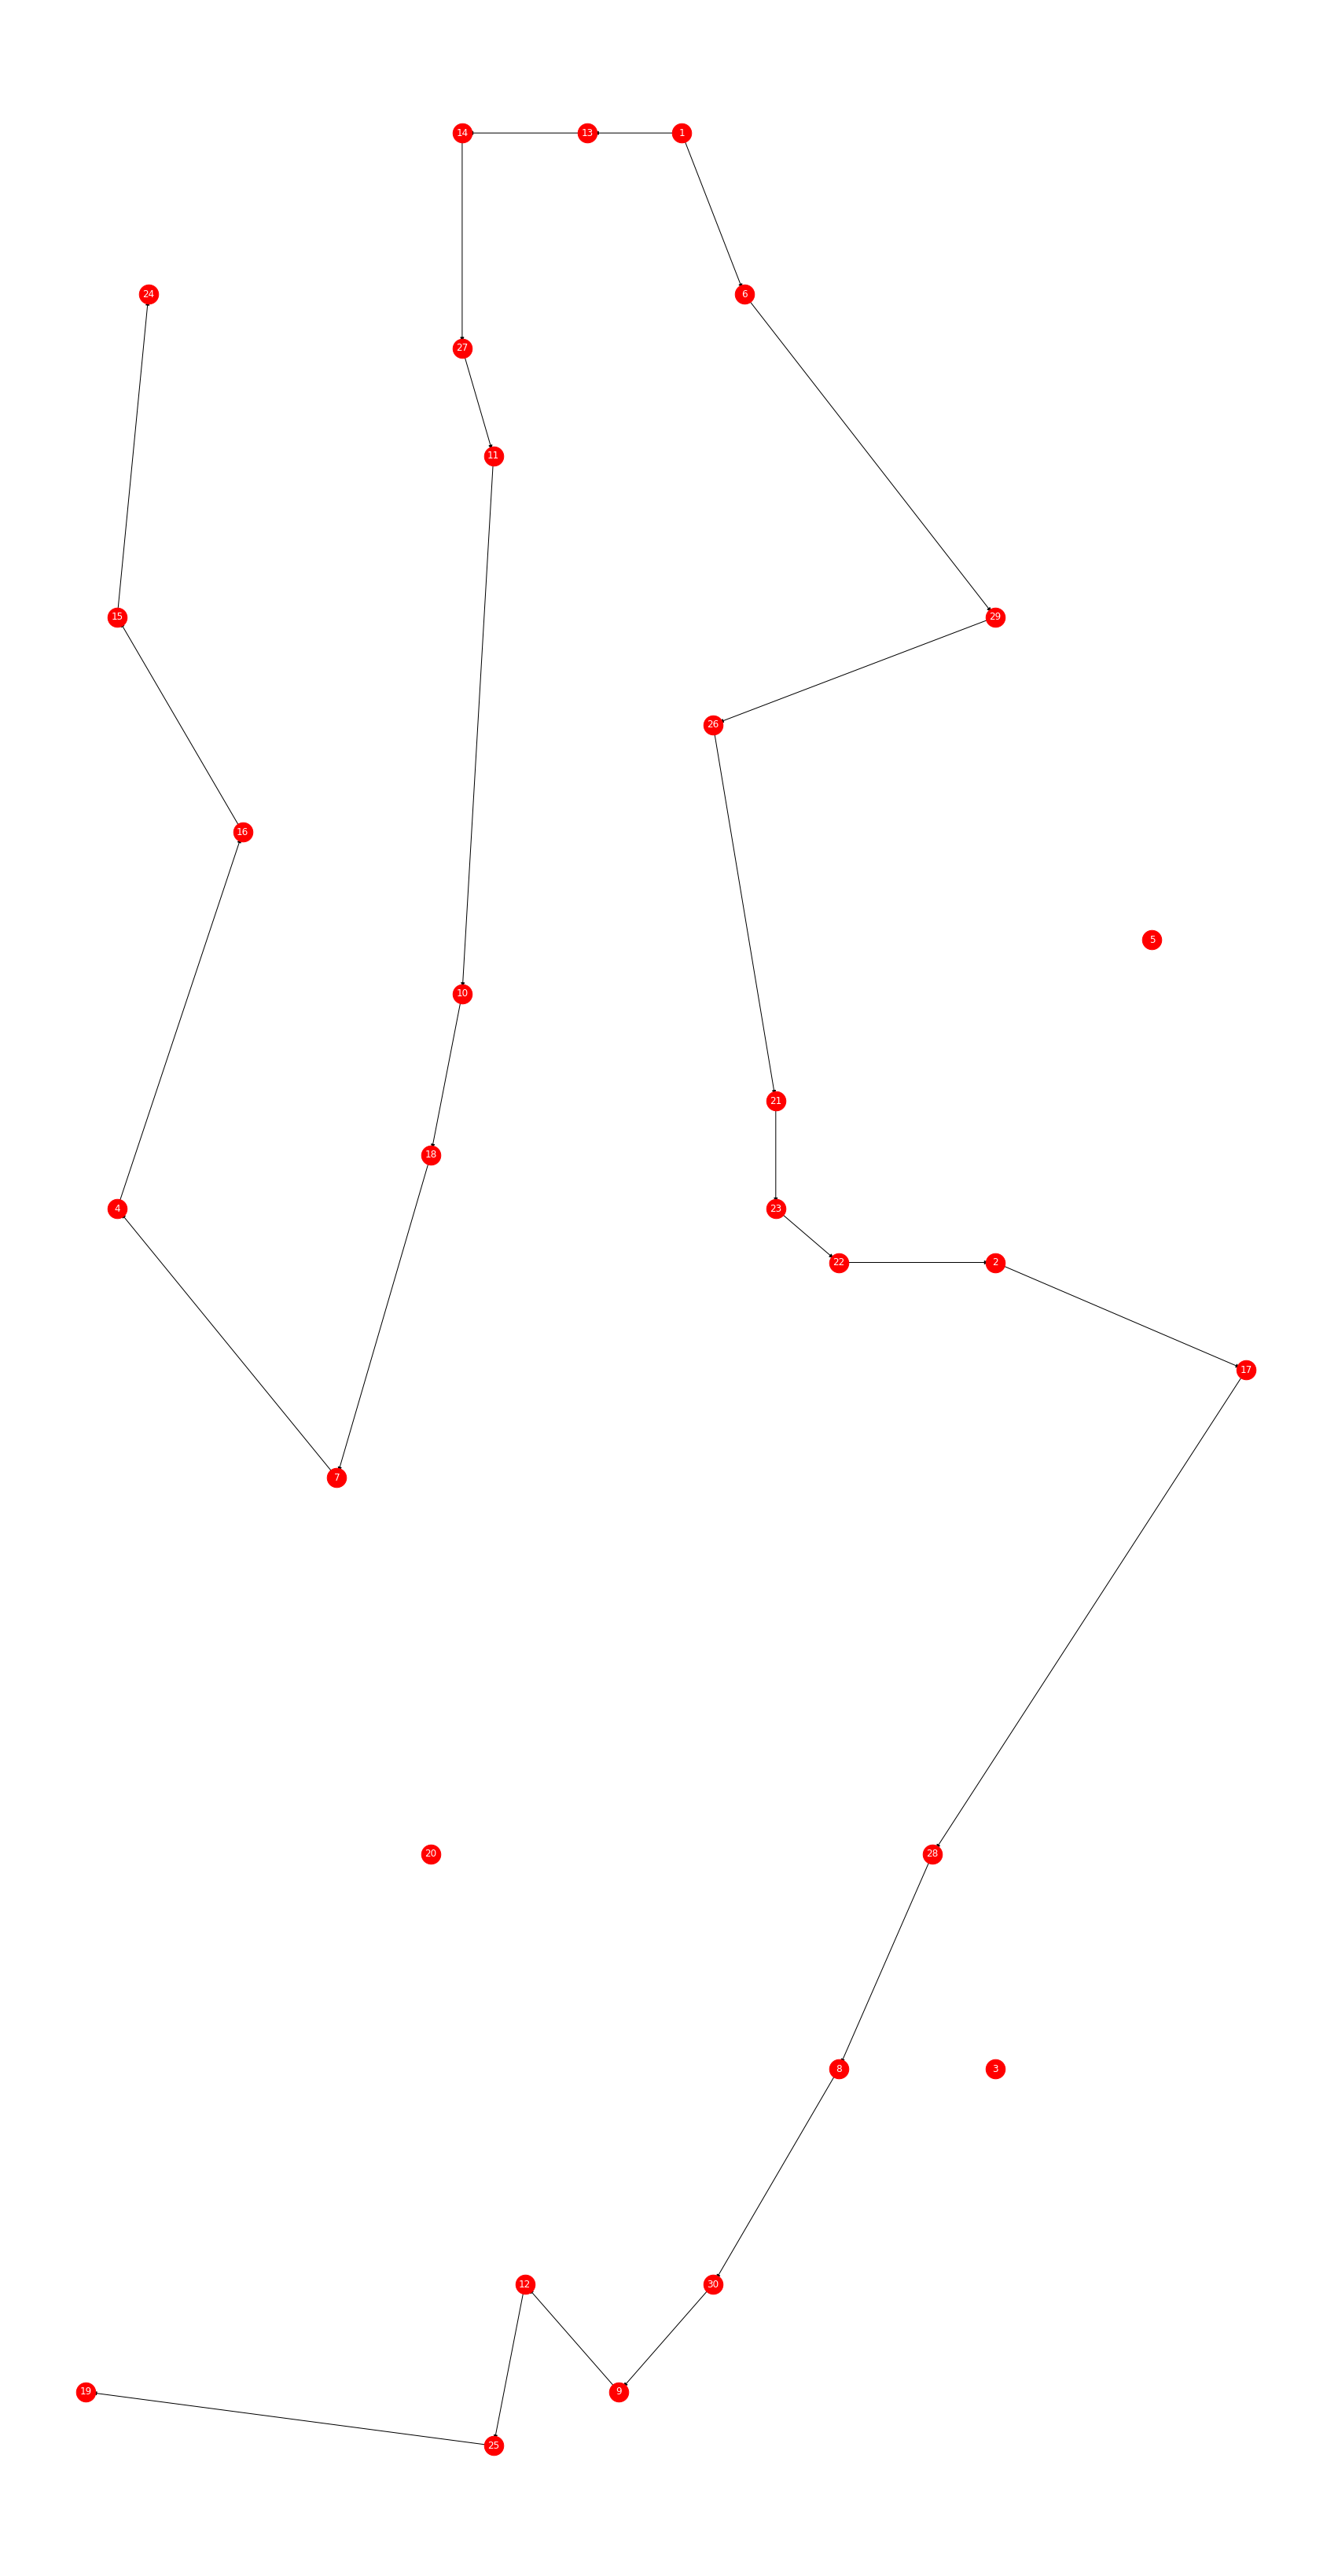

In [39]:
pcst.optimize()

totalcost = 0

for i,j in D.edges():
        if x[i,j].x > 0.1:
            totalcost += D[i][j]['cost']
            
print("\n------------------------------------------------------------------------------\n")
print ("Total cost", totalcost)
print("\n------------------------------------------------------------------------------\n")

# Draw the solution 
DrawSol(D,x)